# Yoseph Yan, ypy4, March 5, 2024, Intelligent Autonomous Systems

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.cluster import KMeans
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Defines the path to the training data
trainpath = 'train'

# Initializes the number of hidden states and observation clusters
N = 15
M = 75

# Initializes the list to store the data
datas = []

# Initializes the list of labels
labels = ["beat3", "beat4", "circle", "eight", "inf", "wave"]

# Loops through the files in the train folder
for txtfile in os.listdir(trainpath):
    # Full path to the files in the train folder
    txtfilepath = os.path.join(trainpath, txtfile)
    
    # Reads the data from the file
    data = pd.read_csv(txtfilepath, sep='\t', header=None, names=['ts', 'Wx', 'Wy', 'Wz', 'Ax', 'Ay', 'Az'])
    datas.append(data)

# Combines the data from all the files into one dataframe
combineddata = pd.concat(datas, ignore_index=True)
combineddata = combineddata.drop(columns=['ts'], axis=1)

# Computes kmeans clustering
kmeans = KMeans(n_clusters=M, random_state=0).fit(combineddata)

In [3]:
# Function that computes the forward algorithm
def forward(pi, A, B, clusters):
    # Number of observations
    T = len(clusters)
    
    # Initializes alpha
    alpha = np.zeros((N, T))
    param = 0

    # Computes alpha
    alpha[:, 0] = pi
    for t in range(1, T):
        alpha[:, t] = ((alpha[:, t - 1]).dot(A)) * B[:, clusters[t]]
        asum = alpha[:, t].sum()
        alpha[:, t] /= asum
        param = np.log(asum)

    # Returns the results
    return alpha, param
    
# Function that computes the backward algorithm
def backward(A, B, clusters):
    # Number of observations
    T = len(clusters)

    # Initializes beta
    beta = np.zeros((N, T))

    # Computes beta
    beta[:, -1] = 1
    for t in range(1, T):
        beta[:, -1 - t] = (A.dot(B[:, clusters[-t]] * beta[:, -t]))
        beta[:, -1 - t] /= beta[:, -1 - t].sum()

    # Returns the results
    return beta

# Function that executes the E-step
def e_step(alpha, beta, clusters, A, B):
    # Number of observations
    T = len(clusters)

    # Initializes xi and gamma
    xi = 0
    gamma = 0

    # Computes xi
    xi = alpha[:, :-1].reshape(N, 1, T - 1) * beta[:, 1:].reshape(1, N, T - 1) * A.reshape(N, N, 1) * B[:, clusters[1:]].reshape(1, N, T - 1)
    xi /= xi.sum()
    
    # Computes gamma
    gamma = alpha * beta
    gamma /= gamma.sum()

    # Returns the results
    return gamma, xi, A, B

# Function that executes the M-step
def m_step(gamma, xi, A, B):
    # Computes A and B
    A = xi.sum(axis=-1) / gamma.sum(axis=-1) + 1e-10
    for cluster in range(M):
        B[:, cluster] = gamma[:, np.where(clusters == cluster)].sum(axis=-1).flatten() / gamma.sum(axis=-1) + 1e-10

    # Returns the results
    return A, B

# Defines the forward-backward algorithm
def train(clusters):
    # Number of observations
    T = len(clusters)

    # Initializes pi, A, and B
    pi = np.random.dirichlet(np.ones(N))
    A = np.random.rand(N, N) + np.eye(N)
    A /= A.sum()
    B = np.random.dirichlet(np.ones(M), size=N)

    # Number of iterations
    lmax = 15
    
    xval = []
    yval = []

    # Loops through the iterations
    for i in range(lmax):
        
        # Computes the forward and backward algorithm and e-step and m-step
        alpha, param = forward(pi, A, B, clusters)
        xval.append(i)
        yval.append(param)
        beta = backward(A, B, clusters)
        gamma, xi, A, B = e_step(alpha, beta, clusters, A, B)
        A, B = m_step(gamma, xi, A, B)
        
    # Plots
    plt.figure(figsize=(4, 3))
    plt.plot(xval, yval)
    plt.xlabel('Epoch')
    plt.ylabel('Log-Likelihood')
    plt.title('Log-Likelihood per Epoch')
    plt.show()

    # Returns the results
    return A, B, pi

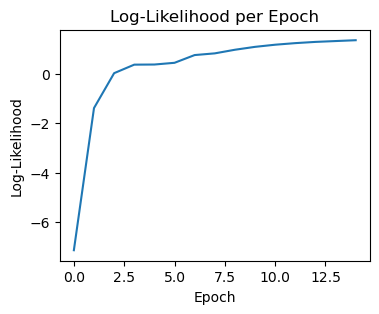

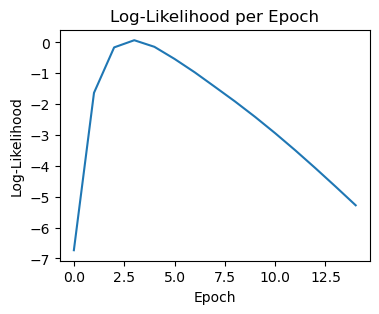

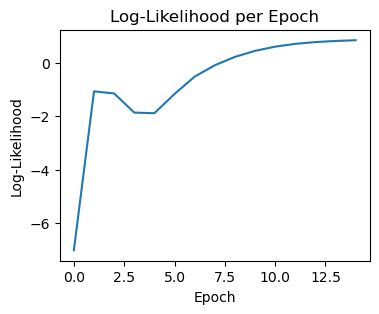

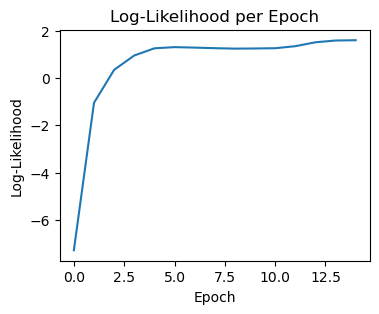

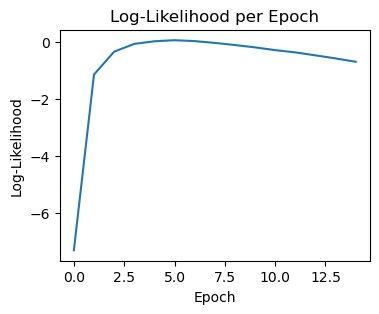

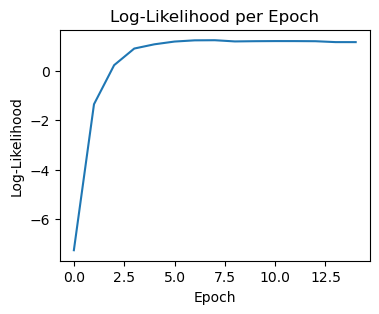

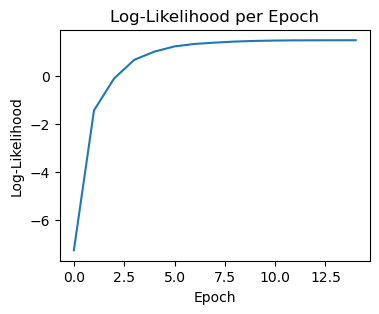

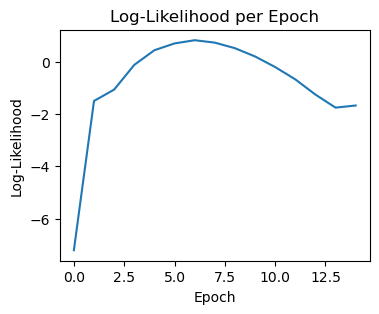

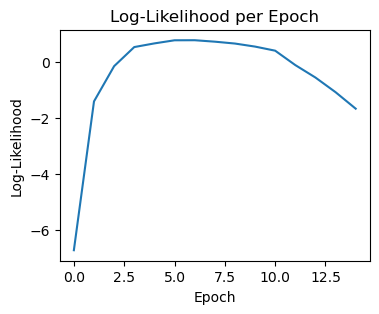

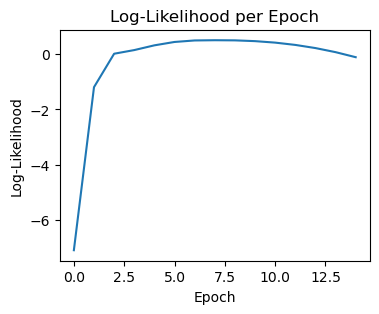

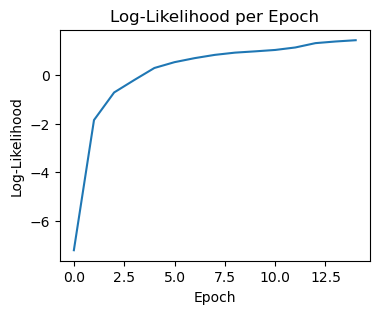

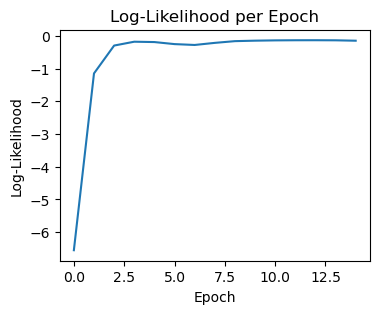

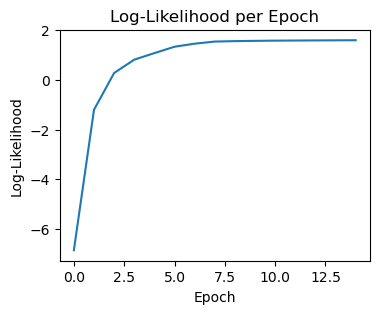

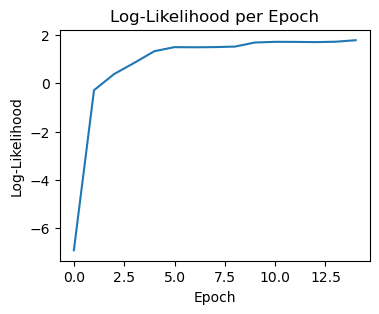

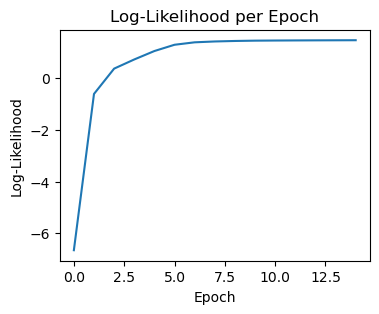

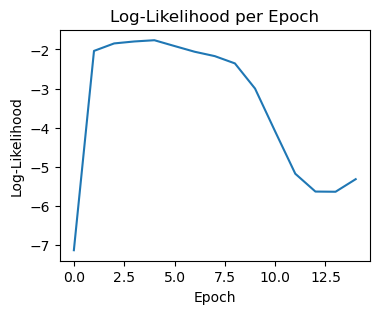

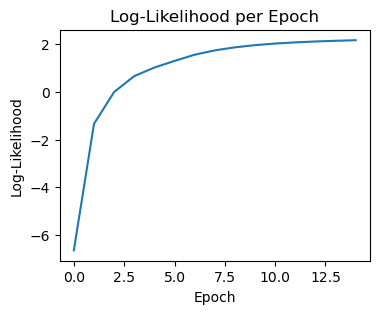

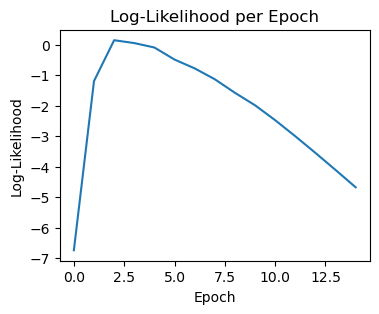

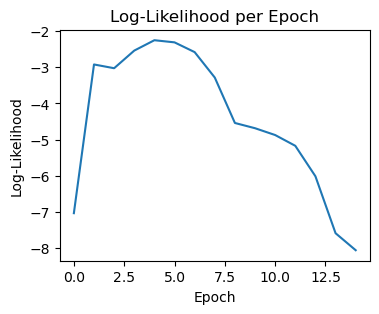

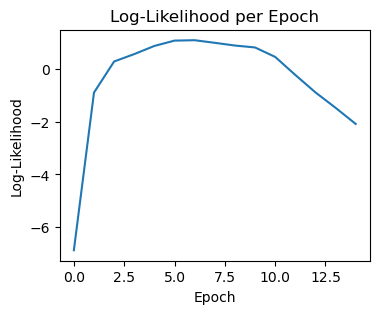

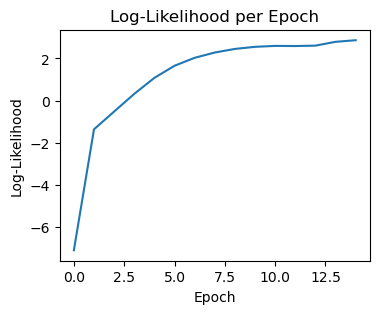

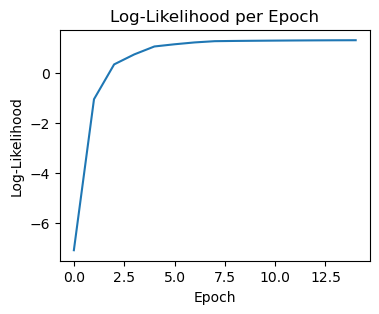

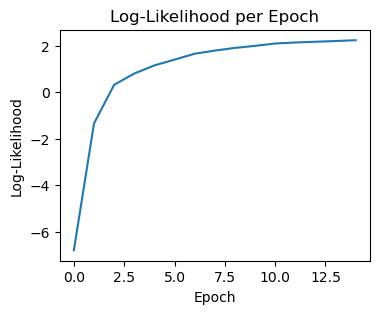

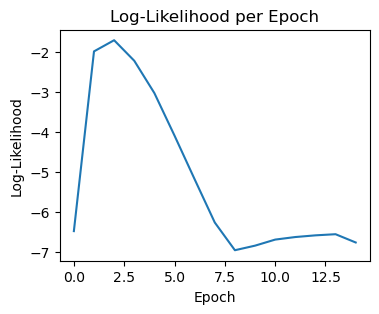

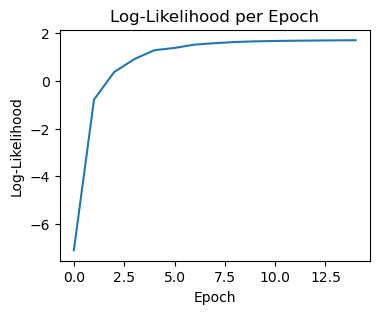

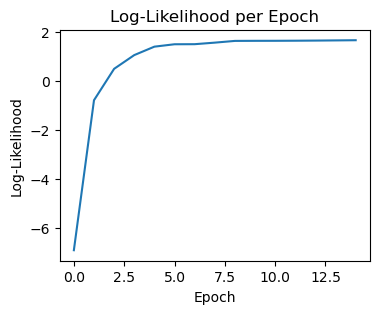

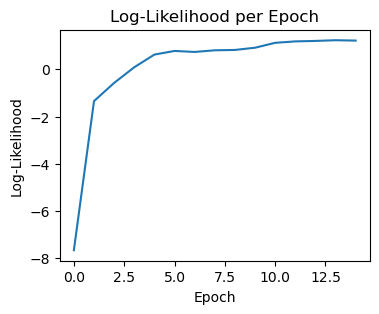

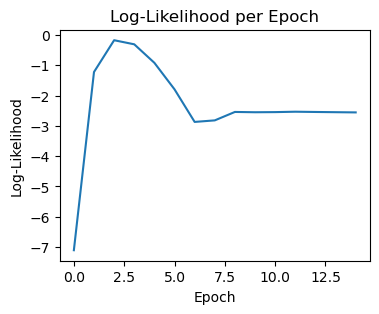

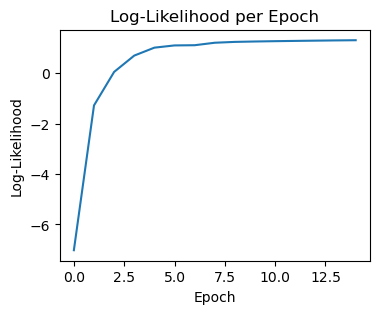

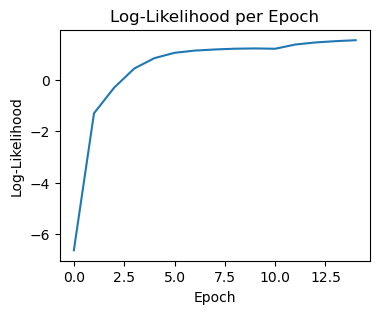

In [4]:
# Initializes the dictionary to store the results
dictionary = {}

# Loops through the labels
for label in labels:
    # Initializes the dictionary for each label
    dictionary[label] = {"pi": np.zeros((N)), "A": np.zeros((N, N)), "B": np.zeros((N, M))}
    
    # Loops through the files in the train folder
    for txtfile in os.listdir(trainpath):
        # If the gesture is in the file name
        if label in txtfile:
            # Full path to the files in the train folder
            txtfilepath = os.path.join(trainpath, txtfile)

            # Reads the data from the file
            data = pd.read_csv(txtfilepath, sep='\t', header=None, names=['ts', 'Wx', 'Wy', 'Wz', 'Ax', 'Ay', 'Az'])
            data = data.drop(columns=['ts'], axis=1)

            # Computes the clusters
            clusters = kmeans.predict(data)

            # Computes the forward-backward algorithm
            a, b, pi = train(clusters)

            # Updates the dictionary
            dictionary[label]["pi"] += pi
            dictionary[label]["A"] += a
            dictionary[label]["B"] += b
            
# Saves object to a file using pickle
with open('model/model.pickle', 'wb') as file:
    pickle.dump(dictionary, file)
    
# Saves object to a file using pickle
with open('model/kmeans.pickle', 'wb') as file:
    pickle.dump(kmeans, file)